# Queries

## 1.  Consider a database with the following schema:

```
Person ( name, age, gender )
name is a key
Frequents ( name, pizzeria )
(name, pizzeria) is a key
Eats ( name, pizza )
(name, pizza) is a key
Serves ( pizzeria, pizza, price )
(pizzeria, pizza) is a key
```


### a. Find all pizzerias frequented by at least one person under the age of 18.

$$ \pi_{pizzeria} \left( \sigma_{age<18} \left( Person \right) \right) $$

`\project_{pizzeria} (\select_{age<18} Person \join Frequents);`

In [4]:
filename = 'task_a.ra'
expression = '''\project_{pizzeria} (
                    \select_{age<18} Person 
                    \join Frequents
                );
             '''
with open(filename, 'w') as f:
    f.write(expression)

In [7]:
%%bash -s "$filename"
radb -i $1

(pizzeria:string)
----------------------------------------------------------------------
Pizza Hut
New York Pizza
Straw Hat
----------------------------------------------------------------------
3 tuples returned


### b.  Find the names of all females who eat either mushroom or pepperoni pizza (or both).

$$ \pi_{pizza} \left( \sigma_{gender='female'}\left( Person \right) \Join \sigma_{pizza='mushroom'\wedge pizza='pepperoni'} \left( Eats \right) \right) $$

In [24]:
filename = 'task_b.ra'
expression = '''\project_{name} (
                    \select_{gender='female'} Person
                    \join
                    \select_{pizza='mushroom' or pizza='pepperoni'} Eats
                );
             '''
with open(filename, 'w') as f:
    f.write(expression)

In [23]:
%%bash -s "$filename"
radb -i $1

(name:string)
----------------------------------------------------------------------
Amy
Fay
----------------------------------------------------------------------
2 tuples returned


### c. Find the names of all females who eat both mushroom and pepperoni pizza.

$$ \pi_{name} \left(\sigma_{gender='female'\, AND \, pizza='mushroom'} \left( Person \Join Eats \right) \right) \cap \pi_{name} \left(\sigma_{gender='female'\, AND \, pizza='pepperoni'} \left( Person \Join Eats \right) \right) $$

In [39]:
filename = 'task_c.ra'
expression = r'''\project_{name} (
                   \select_{gender='female' and pizza='mushroom'}
                       (Person \join Eats)
                 )
                 \intersect
                 \project_{name} (
                   \select_{gender='female' and pizza='pepperoni'}
                       (Person \join Eats)
                 )
                ;
             '''
with open(filename, 'w') as f:
    f.write(expression)

In [40]:
%%bash -s "$filename"
radb -i $1

(name:string)
----------------------------------------------------------------------
Amy
----------------------------------------------------------------------
1 tuple returned


### d. Find all pizzerias that serve at least one pizza that Amy eats for less than $10.00.

$$ \pi_{pizzeria} \left(\sigma_{name='Amy'\, AND \, price<10} \left( Eats \Join Serves \right) \right)$$
or more efficient version:
$$ \pi_{pizzeria} \left(\sigma_{name='Amy'} \left( Eats \right) \Join \sigma_{price<10} \left( Serves \right) \right)$$

In [42]:
filename = 'task_d.ra'
expression = r'''\project_{pizzeria} (\select_{name='Amy' and price<10} (Eats \join Serves));
             '''
with open(filename, 'w') as f:
    f.write(expression)

In [43]:
%%bash -s "$filename"
radb -i $1

(pizzeria:string)
----------------------------------------------------------------------
Little Caesars
New York Pizza
Straw Hat
----------------------------------------------------------------------
3 tuples returned


### e. Find all pizzerias that are frequented by only females or only males.

$$ \pi_{pizzeria} \left(\sigma_{gender='female'} \left( Person \Join Frequents \right) \right) \cap \pi_{pizzeria} \left(\sigma_{gender='male'} \left( Person \Join Frequents \right) \right) $$

In [46]:
filename = 'task_e.ra'
expression = r'''\project_{pizzeria} (
                    \select_{gender='male'} (Person \join Frequents))
                 \intersect
                 \project_{pizzeria} (
                    \select_{gender='female'} (Person \join Frequents)) 
                ;
             '''
with open(filename, 'w') as f:
    f.write(expression)

In [49]:
%%bash -s "$filename"
radb -i $1

(pizzeria:string)
----------------------------------------------------------------------
Dominos
Pizza Hut
Straw Hat
----------------------------------------------------------------------
3 tuples returned


### f. For each person, find all pizzas the person eats that are not served by any pizzeria the person frequents. Return all such person (name) / pizza pairs.

$$ Eats -  \pi_{name,pizza} \left(\ Frequents \Join Serves \right)  $$

In [50]:
filename = 'task_f.ra'
expression = r'''Eats 
                    \diff
                      \project_{name, pizza} (
                          Frequents 
                          \join
                          Serves
                      ) 
                ;
             '''
with open(filename, 'w') as f:
    f.write(expression)

In [51]:
%%bash -s "$filename"
radb -i $1

(name:string, pizza:string)
----------------------------------------------------------------------
Amy, mushroom
Dan, mushroom
Gus, mushroom
----------------------------------------------------------------------
3 tuples returned


### g. Find the names of all people who frequent only pizzerias serving at least one pizza they eat.

$$ \pi_{name} \left(\ Person \right) - \left(\ Frequents - \pi_{name,pizzeria} \left( Eats \Join Serves \right) \right)  $$

In [81]:
filename = 'task_g.ra'
expression = r'''\project_{name} (Person)
                 \diff (
                     \project_{name} (
                     Frequents
                     \diff
                     \project_{name, pizzeria} (
                          Eats
                          \join
                          Serves
                      )));
             '''
with open(filename, 'w') as f:
    f.write(expression)

In [82]:
%%bash -s "$filename"
radb -i $1

(name:string)
----------------------------------------------------------------------
Amy
Ben
Dan
Eli
Fay
Gus
Hil
----------------------------------------------------------------------
7 tuples returned


### h. Find the names of all people who frequent every pizzeria serving at least one pizza they eat.

$$ \pi_{name} \left( Person \right) - \left( \pi_{name,pizzeria} \left( Eats \Join Serves \right) - Frequents \right)  $$

In [83]:
filename = 'task_h.ra'
expression = r'''\project_{name} (Person)
                 \diff (
                     \project_{name} (
                     \project_{name, pizzeria} (
                          Eats
                          \join
                          Serves
                      )
                      \diff
                      Frequents
                      ));
             '''
with open(filename, 'w') as f:
    f.write(expression)

In [84]:
%%bash -s "$filename"
radb -i $1

(name:string)
----------------------------------------------------------------------
Fay
----------------------------------------------------------------------
1 tuple returned


### i. Find the pizzeria serving the cheapest pepperoni pizza. In the case of ties, return all of the cheapest-pepperoni pizzerias.

$$
\pi_{pizzeria}
    \left(
        \sigma_{pizza='pepperoni'}Serves
    \right)
$$

$$-$$

$$
\pi_{pizzeria}
    \lbrack
$$

$$
        \sigma_{price>price2}
            \left(
                \pi_{pizzeria, price}
                \left(
                    \sigma_{pizza='pepperoni'}Serves
                \right)
            \right)
$$

$$\times$$

$$            
        \rho_{pizzeria2,price2}
        \pi_{pizzeria, price}
            \left(
                \sigma_{pizza='pepperoni'}Serves
            \right)
$$

$$
    \rbrack
$$

In [89]:
filename = 'task_i.ra'
expression = r'''\project_{pizzeria} (
                    \select_{pizza='pepperoni'} Serves)
                 \diff
                 \project_{pizzeria} (
                     \select_{price>price2} (
                         \project_{pizzeria,price} (
                             \select_{pizza='pepperoni'} Serves
                         )
                         \cross
                         \rename_{pizzeria2,price2}
                             \project_{pizzeria,price} (
                                 \select_{pizza='pepperoni'} Serves
                             )
                    )
                 );
             '''
with open(filename, 'w') as f:
    f.write(expression)

In [90]:
%%bash -s "$filename"
radb -i $1

(pizzeria:string)
----------------------------------------------------------------------
New York Pizza
Straw Hat
----------------------------------------------------------------------
2 tuples returned


## Problem No. 2.

> *Consider a schema with two relations, R(A, B) and S(B, C), where all values are integers. Make no assumptions about keys. Consider the following three relational algebra expressions:*

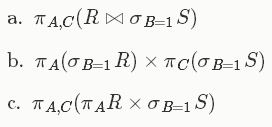

> *Two of the three expressions are equivalent (i.e., produce the same answer on all databases), while one of them can produce a different answer. Which query can produce a different answer? Give the simplest database instance you can think of where a different answer is produced.*

## Solution to Task 2:

 ## Problem No. 3
 > *Consider a relation R(A, B) that contains r tuples, and a relation S(B, C) that contains s tuples; assume r > 0 and s > 0. Make no assumptions about keys. For each of the following relational algebra expressions, state in terms of r and s the minimum and maximum number of tuples that could be in the result of the expression.*

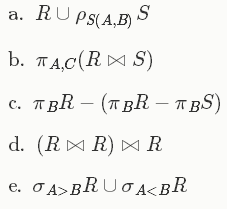

## Solution to Task 3: